<h1> Linear Quantum Measurement Error Mitigation </h1>

Based on IBM's qiskit tutorial on Measurement Error Mitigation:
https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

IBM Quantum Experience:
https://quantum-computing.ibm.com/

Qiskit documentation:
https://qiskit.org/documentation/

In [5]:
# Important global variables

N_QUBITS = 5
SHOTS = 8192

# https://quantum-computing.ibm.com/  ->  Your profile  ->  'Copy token'
# Note: should be a string
IBMQ_TOKEN = ""

In [2]:
# Import needed functions from qiskit

from qiskit import QuantumCircuit

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from qiskit.providers.ibmq import least_busy

from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt

# Other dependencies are: numpy, scipy

# 'magic function' which adds jupyter graphic interface for monitoring IBMQ jobs
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [3]:
# Import and initialize own classes for handling IBMQ simulation and execution, as well as the error mitigation

from IBMQHandler import IBMQHandler
from MeasurementErrorMitigation import MeasurementErrorMitigation, build_vector, build_dict

ibmq_handler = IBMQHandler(n_qubits=N_QUBITS,shots=SHOTS)
measurement_error_mitigation = MeasurementErrorMitigation(n_qubits=N_QUBITS)

In [6]:
# authenticate against IBM Quantum Experience

ibmq_handler.enable_account(IBMQ_TOKEN)

In [20]:
# To test the quantum error mitigation at the end, we construct some test circuits and mitigate errors in the output of these.
# Computational basis states: |x_4 x_3 x_2 x_1 x_0> where x_i in {0,1}. Write states only up to normalization.

# Test circuit 1
# ideal output -> the quantum state: |ksi> = |00000> + |00101>
def build_test_circuit(n_qubits: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n_qubits)
    
    circuit.h(0)
    circuit.cx(0,2)
    
    circuit.measure_all()
    
    return circuit

test_circuit = build_test_circuit(N_QUBITS)

test_circuit.draw()

# Test circuit 2
# ideal output -> the quantum state: |ksi> = |00000> + |11111>
def build_test_circuit_2(n_qubits: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n_qubits)
    
    circuit.h(0)
    for i in range(1,n_qubits):
        circuit.cx(0,i)
        
    circuit.measure_all()
    
    return circuit

# Test circuit 3
# ideal output -> |cat_5>, the equal superposition of all computation basis states
def build_test_circuit_cat(n_qubits: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n_qubits)
    
    for i in range(n_qubits):
        circuit.h(i)
    
    circuit.measure_all()
    
    return circuit

<h2>Error mitigation on a simulated circuit</h2>

In this section we define a simple error model, and then do measurement error mitigation on a simulated quantum computer using said error model.

In [ ]:
# We define a noise model.

# The space of single-qubits unitaries is spanned by the Pauli Group {I, X, Z, Y} on each qubit, Y = XZ.
# Thus a natural starting point.

def create_noise_model(p: float) -> NoiseModel:
    measurement_errors = pauli_error([('X',p/3),('Z',p/3),('Y',p/3),('I',1-p)])
    
    noise_model = NoiseModel()
    
    noise_model.add_all_qubit_quantum_error(measurement_errors,'measure')
    
    return noise_model

noise_model = create_noise_model(0.05)

In [ ]:
# Build the mitigation circuits, consisting of 2**n_qubits circuits each constructing one of
# the 2**n_qubits computational basis states.

mitigation_circuit = measurement_error_mitigation.build_mitigation_circuit()

job = ibmq_handler.simulate_quantum_circuit(circuit=mitigation_circuit, noise_model=noise_model)
results_mitigation_circuit_sim = job.result().get_counts()

print(results_mitigation_circuit_sim[0])

In [ ]:
# Build the 2**n_qubits x 2**n_qubits error mitigation matrix

measurement_error_mitigation.build_error_mitigation_matrix(
                                results_mitigation_circuit_sim)

error_mitigation_matrix_simulated = measurement_error_mitigation.error_mitigation_matrix

print(error_mitigation_matrix_simulated)

In [ ]:
# Simulate the test circuit for an ideal quantum computer, i.e. without noise:

job = ibmq_handler.simulate_quantum_circuit(circuit=test_circuit)
results_ideal_simulated = job.result().get_counts()

# Then with out pauli noise model:

job = ibmq_handler.simulate_quantum_circuit(circuit=test_circuit, noise_model=noise_model)
results_noisy_simulated = job.result().get_counts()

# Then at last, we use our error mitigation matrix to mitigate measurement errors in the noisy results

job = measurement_error_mitigation.mitigate_errors(results_noisy_simulated)
results_mitigated_simulated = job.result().get_counts()

In [ ]:
# Plot the results

plot_histogram([results_ideal_simulated, results_noisy_simulated, results_mitigated_simulated],
               legend = ["ideal","noisy","noisy, mitigated"])

<h2>Error Mitigation on a physical quantum computer</h2>

Here, we do measurement error mitigation on one of IBM's openly available, physical quantum computers.

In [8]:
# Find the currently least busy IBMQ backend

ibmq_handler.find_least_busy()

ibmq_london


In [ ]:
# Or alternatively set a specific, e.g. 'ibmq_london'

BACKEND_NAME = "ibmq_london"

ibmq_handler.set_specific_backend(BACKEND_NAME)

In [9]:
# run the mitigation circuit on a physical quantum computer

mitigation_circuit = measurement_error_mitigation.build_mitigation_circuit()

job = ibmq_handler.run_quantum_circuit_on_IBMQ(mitigation_circuit)

In [ ]:

# or alternatively retrieve results from a previously run job

job_id = "" # job_id as a string

job = ibmq_handler.retrieve_result(job_id)

In [10]:
# extract the measurement result counts and build mitigation matrix

results_mitigation_circuit_physical = job.result().get_counts()

print(results_mitigation_circuit_physical[0])

{'10001': 2, '00110': 9, '10000': 234, '00001': 32, '00011': 4, '10010': 4, '00101': 2, '10100': 20, '00111': 1, '00000': 7176, '00100': 549, '01100': 4, '01000': 42, '00010': 113}


In [11]:
# build the error mitigation matrix based on measurement results from the physical quantum computer

measurement_error_mitigation.build_error_mitigation_matrix(results_mitigation_circuit_physical)

mitigation_matrix_physical = measurement_error_mitigation.error_mitigation_matrix

print(mitigation_matrix_physical)

[[ 1.15873879e+00 -5.35705832e-03 -1.87330469e-02 ... -4.30851870e-07
   1.35453752e-05 -4.80921863e-08]
 [-8.75732145e-02  1.20821614e+00  1.04205227e-03 ... -3.20587096e-05
  -1.21415942e-06 -1.10583575e-06]
 [-9.82134763e-02  5.55114374e-04  1.19384483e+00 ... -1.20548904e-07
  -9.68736998e-07  2.22888416e-07]
 ...
 [-9.45443415e-05 -1.44348065e-04 -2.22012882e-05 ...  1.39247515e+00
   1.89260018e-03 -1.51234950e-02]
 [ 8.84497242e-05  1.39154626e-05 -6.60866395e-04 ...  2.03541256e-04
   1.35962871e+00 -5.70271797e-03]
 [ 3.24649565e-05  5.30809206e-05 -2.82074107e-06 ... -1.13344725e-01
  -9.58517143e-02  1.44968435e+00]]


Run test circuit 1 with error mitigation

Ideal output: $|ksi> = |00000> +\, |00101>$

In [12]:
test_circuit = build_test_circuit(N_QUBITS)

job = ibmq_handler.run_quantum_circuit_on_IBMQ(test_circuit)

test_circuit.draw()

In [13]:
# extracting measurement result counts

results_test_circuit_physical = job.result().get_counts()

results_test_circuit_mitigated = measurement_error_mitigation.mitigate_errors(results_test_circuit_physical)

results_test_circuit_ideal = {"00000": int(SHOTS / 2), "00101": int(SHOTS / 2)}

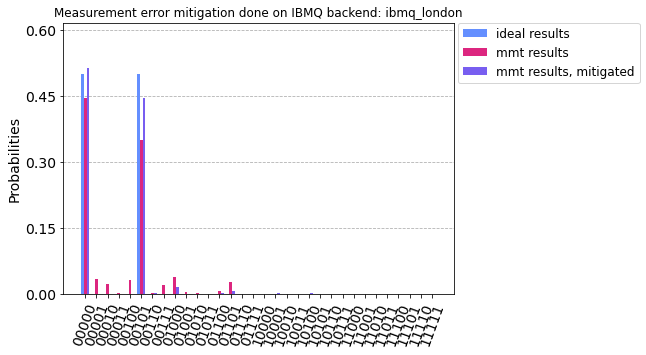

In [14]:
plot_histogram( [results_test_circuit_ideal,
                 results_test_circuit_physical,
                 results_test_circuit_mitigated],
                 title = "Measurement error mitigation done on IBMQ backend: {0}"
                       .format(ibmq_handler.physical_backend.name()),
                 legend = ["ideal results", "mmt results", "mmt results, mitigated"],
                 bar_labels=False)

In [29]:
print("State |00000>")
print("True prob:\t",results_test_circuit_ideal["00000"]/SHOTS)
print("Measured prob:\t",results_test_circuit_physical["00000"]/SHOTS)
print("Mitigated prob:\t",results_test_circuit_mitigated["00000"]/SHOTS,"\n-")

print("State |00101>")
print("True prob:\t",results_test_circuit_ideal["00101"]/SHOTS)
print("Measured prob:\t",results_test_circuit_physical["00101"]/SHOTS)
print("Mitigated prob:\t",results_test_circuit_mitigated["00101"]/SHOTS)

State |00000>
True prob:	 0.5
Measured prob:	 0.4451904296875
Mitigated prob:	 0.511962890625 
-
State |00101>
True prob:	 0.5
Measured prob:	 0.3511962890625
Mitigated prob:	 0.4429931640625


Run test circuit 2 with error mitigation

Ideal output: $|ksi> = |00000> +\, |11111>$

In [21]:
test_circuit_2 = build_test_circuit_2(N_QUBITS)

job = ibmq_handler.run_quantum_circuit_on_IBMQ(test_circuit_2)

test_circuit_2.draw()

┌───┐                     ░ ┌─┐            
   q_0: ┤ H ├──■────■────■────■───░─┤M├────────────
        └───┘┌─┴─┐  │    │    │   ░ └╥┘┌─┐         
   q_1: ─────┤ X ├──┼────┼────┼───░──╫─┤M├─────────
             └───┘┌─┴─┐  │    │   ░  ║ └╥┘┌─┐      
   q_2: ──────────┤ X ├──┼────┼───░──╫──╫─┤M├──────
                  └───┘┌─┴─┐  │   ░  ║  ║ └╥┘┌─┐   
   q_3: ───────────────┤ X ├──┼───░──╫──╫──╫─┤M├───
                       └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                            └───┘ ░  ║  ║  ║  ║ └╥┘
meas_0: ═════════════════════════════╩══╬══╬══╬══╬═
                                        ║  ║  ║  ║ 
meas_1: ════════════════════════════════╩══╬══╬══╬═
                                           ║  ║  ║ 
meas_2: ═══════════════════════════════════╩══╬══╬═
                                              ║  ║ 
meas_3: ══════════════════════════════════════╩══╬═
                                                 ║ 
meas_4: ═════════════════════════════════════════╩═

In [24]:
# extracting measurement result counts

results_test_circuit_physical_2 = job.result().get_counts()

results_test_circuit_mitigated_2 = measurement_error_mitigation.mitigate_errors(results_test_circuit_physical_2)

results_test_circuit_ideal_2 = {"00000": int(SHOTS / 2), "11111": int(SHOTS / 2)}

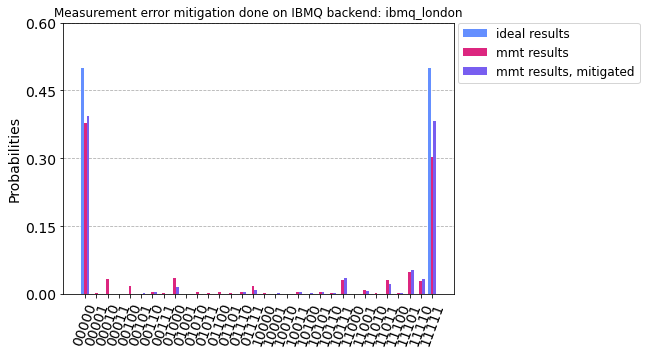

In [25]:
plot_histogram( [results_test_circuit_ideal_2,
                 results_test_circuit_physical_2,
                 results_test_circuit_mitigated_2],
                 title = "Measurement error mitigation done on IBMQ backend: {0}"
                       .format(ibmq_handler.physical_backend.name()),
                 legend = ["ideal results", "mmt results", "mmt results, mitigated"],
                 bar_labels=False)

Run test circuit 3 with error mitigation

Ideal output: $|ksi>\, =\, |cat_{5}>\, =\, \sum_{x \in \{0,1\}^5} |x>$

In [30]:
test_circuit_3 = build_test_circuit_cat(N_QUBITS)

job = ibmq_handler.run_quantum_circuit_on_IBMQ(test_circuit_3)

test_circuit_3.draw()

In [32]:
# extracting measurement result counts

results_test_circuit_physical_3 = job.result().get_counts()

results_test_circuit_mitigated_3 = measurement_error_mitigation.mitigate_errors(results_test_circuit_physical_3)

results_test_circuit_ideal_3 = {}
for i in range(2**N_QUBITS):
    bit_string = '{0:0{1}b}'.format(i, N_QUBITS)
    results_test_circuit_ideal_3[bit_string] = int(SHOTS / (2**N_QUBITS))

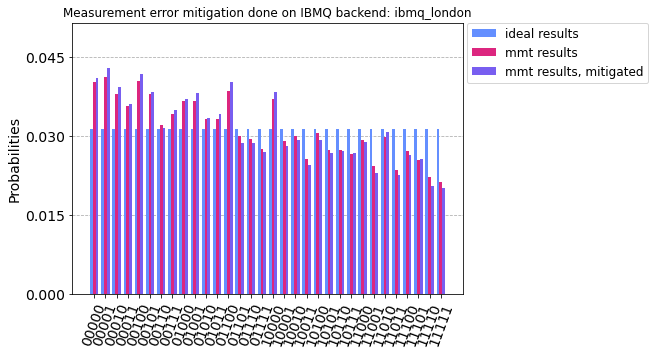

In [34]:
plot_histogram( [results_test_circuit_ideal_3,
                 results_test_circuit_physical_3,
                 results_test_circuit_mitigated_3 ],
                 title = "Measurement error mitigation done on IBMQ backend: {0}"
                       .format(ibmq_handler.physical_backend.name()),
                 legend = ["ideal results", "mmt results", "mmt results, mitigated"],
                 bar_labels=False)